#### Input dataset ?
- I will be using the cleaned dataset after the initial EDA.

#### What is the purpose of this notebook?
- The number and nature of accidents in the aviation industry do not lean to any obiously particular location or type. 
- When I started with the topic, I was interested in finding patterns in the accidents. The Univariate analysis and bivariate analysis provides very interesting insights about the past accidents. Reading through the accident causes, I realized the accidents could have another angle added to it apart from the provided categorical features. The Narrative field is a textual description of the incident. I am interested in adding another dimension i.e. categorizing based on the words in the description.

#### What is the expected output of this notebook?
- I plan to achieve the following at the end of this notebook:
    - Check frequently used words in the summary using NLP/Count Vectorizer
    - Remove stop words iteratively using NLTK
    - Categorize words I think are common causes of accidents. eg: pilot error, weather, hijack and many mroe that I hope to find during the course of this project.
    - Map the frequent words found to the common causes of accidents.
    - This would help me to classify the incidents or to find clusters based on the results of this notebook.

## Import Clean Dataset

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = './dataset/01_aviation_cleaned.csv'

In [4]:
data = pd.read_csv(path)

## Natural Language Processing with the Incident Summary

In [5]:
# Import library 

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models, matutils
from collections import defaultdict
import string
from nltk import word_tokenize 
import pycountry

### These are the stop words for the Narrative - This is going to be a live list.
- English stop words
- Country name stop words
- Common aviation terms like airplane, airline etc

In [6]:
# Creating stop words database for all the numbers
stop = stopwords.words('english')
stop += ['00', '000', '01', '02', '03', '04', '04r', '05', '050', '05l', '05r', '06', '06r', '07', '08', '080', '09', '09r', '10', '100', '1000', '10000', '102', '103', '104', '1049', '105', '106', '107', '108', '109', '10deg', '10l', '11', '110', '1100', '111', '111f', '112', '113', '114', '115', '116', '117', '118', '118a', '119', '11f', '11s', '12', '120', '1200', '12000', '121', '361', '376','122', '123', '124', '124c', '125', '128', '129', '12bk', '13', '130', '1300', '130b', '130e', '130h', '130j', '131', '133', '134', '135', '135a', '139', '13l', '14', '140', '1400', '141', '1420', '145', '14500', '146', '148', '15', '150', '1500', '153', '154', '157', '158', '159', '15deg', '16', '160', '1600', '163', '165', '166', '168', '16r', '17', '170', '1700', '172', '175', '1750', '17l', '18', '180', '1800', '180deg', '185', '188', '19', '190', '1900', '1900c', '1900d', '191', '1936', '1938', '1940', '1941', '1942', '1943', '1944', '1945', '1948', '1949', '1950', '1951', '1953', '1954', '1955', '1957', '1963', '1964', '1966', '1968', '1969', '1972', '1973', '1974', '1978', '1979', '1980', '1981', '1982', '1983', '1985', '1986', '1988', '1990', '1991', '1992', '1993', '1994', '1997', '1998', '1999', '19r', '1a', '1a10', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '200c', '201', '2011', '2013', '2015', '202', '203', '2050', '207', '208', '208b', '20deg', '21', '210', '211', '212', '215', '22', '220', '2200', '222', '225', '227', '228', '22l', '23', '230', '2300', '232', '235', '24', '240', '2400', '241', '242', '24b', '24l', '24r', '24rv', '25', '250', '2500', '25l', '26', '260', '265', '266', '26b', '26l', '27', '270', '2700', '27l', '27r', '28', '280', '2800', '285', '28l', '28r', '29', '290', '29l', '2a', '2r', '2t', '30', '300', '3000', '304', '306', '30deg', '31', '310', '31242', '31243', '314', '315', '31l', '31r', '32', '320', '3200', '320o', '322', '325', '328', '32l', '32r', '33', '330', '3300', '330o', '336', '338', '33l', '34', '340', '340b', '340o', '345', '35', '350', '3500', '350o', '35a', '35l', '36', '360', '3600', '37', '38', '39', '390', '3a', '3c', '3deg', '3m', '3mge', '3t', '40', '400', '4000', '41', '410', '410uvp', '42', '420', '4200', '43', '430', '436', '44', '440', '45', '450', '4500', '45deg', '46', '46d', '47', '470', '4700', '47a', '47b', '47d', '47s', '48', '49', '50', '500', '5000', '501', '504', '50832', '50deg', '51', '52', '525', '53', '54', '5400', '55', '550', '5500', '56', '57', '58', '580', '59', '5a', '5h', '5n', '5nm', '5y', '60', '600', '6000', '601', '61', '610', '62', '620', '63', '631', '64', '640', '65', '650', '6500', '66', '67', '68', '6a', '6e', '70', '700', '7000', '707', '71', '710', '72', '720', '725', '727', '73', '737', '74', '747', '748', '75', '750', '7500', '756', '757', '76', '767', '767s', '76md', '770', '777', '78', '78505', '7nm', '80', '800', '8000', '801', '81', '811', '812', '82', '8235', '8241', '82a', '83', '84', '85', '850', '8500', '86', '87', '88', '8807', '89', '8q', '8th', '90', '900', '9000', '90deg', '91', '910', '92', '93', '931', '94', '95', '96', '97', '98', '99', '990', '9k', '9n', '9q', 'a100', 'a300', 'a310', 'a319', 'a320', 'a321', 'a330', 'a6m2', 'aa', 'aaa', 'aab', 'aaf', 'ab', 'ababa']
stop += ['08r', '1009', '101', '1011', '104b', '144', '21st', '221', '22285', '231', '23l', '300yds', '301', '3100', '318', '319', '31de', '321', '321b', '324', '3277', '33666', '33r', '380', '3800', '395', '39a', '3mce', '400a', '402q', '40563', '40deg', '415', '42e', '42w', '4300', '451', '460', '701', '702', '712', '730', '740', '75a', '76td', '7700', '775', '780', '78270', '78462', '785', '797', '800xp', '823', '841', '8as', '8r', '901', '919', '920', '926', '980', '9j', '9l', '9m']
stop += ['675','680','6800','6b']
stop += ['airport', 'airplane','aircraft', 'approach',
 'crashed','crew','feet','flight','following','main','members','near','one','operated','passenger','passengers','plane','runway','struck','substantial','sustained','three','took','two','boeing','dc','due','beyond',
 'damaged','b200','repair', 'miles', 'km', 'air', 'lines', 'departed', 'abort', 'takeoff', 'landing', 'reported', 'airline', 'captain'
 ]


In [7]:
# Add all countries as stop words
for c in list(pycountry.countries):
    stop.append(c.name.lower())

### Stemmer - I dont think I will use it though

In [8]:
stemmer = PorterStemmer()

In [9]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    print(stems)
    return stems

### Count Vectorizer to get the most commonly used vocabulary

In [10]:
# vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
#                              preprocessor = None,stop_words = stop,max_features = 1000, ngram_range = (1,1)) 

vectorizer = CountVectorizer(stop_words = stop) 
X = vectorizer.fit_transform(data['Narrative'])

In [11]:
X.shape

(8172, 16166)

In [12]:
vectorizer.vocabulary_
vectorizer.get_feature_names()

['000ft',
 '001',
 '0014',
 '002',
 '003',
 '006',
 '010',
 '010º',
 '0127',
 '015',
 '017',
 '0171',
 '0173',
 '0195',
 '01l',
 '01r',
 '020',
 '020deg',
 '0218',
 '022',
 '024',
 '0256',
 '02801',
 '02r',
 '030',
 '030º',
 '0326',
 '0328',
 '040',
 '040b',
 '040deg',
 '044',
 '045',
 '0450',
 '0462',
 '0463',
 '049',
 '04l',
 '053',
 '0597',
 '060',
 '0602',
 '060deg',
 '061',
 '064',
 '069',
 '06l',
 '070',
 '0703',
 '0705',
 '0719',
 '072',
 '0730',
 '07308',
 '075deg',
 '076',
 '07l',
 '07r',
 '0839',
 '085',
 '0850',
 '08l',
 '090',
 '0900',
 '090deg',
 '092',
 '094',
 '0970',
 '0972',
 '0981',
 '09l',
 '1002',
 '1006',
 '1007',
 '1008',
 '100912',
 '100deg',
 '100e',
 '100er',
 '100nm',
 '100yds',
 '10100',
 '1015',
 '1018',
 '1020',
 '10200',
 '1024',
 '1025',
 '1027',
 '10350',
 '1036',
 '1040',
 '1041k',
 '104g',
 '1050',
 '10500',
 '1054',
 '10554',
 '1058',
 '1060',
 '10687',
 '1069',
 '1070',
 '10737',
 '1074',
 '1075',
 '1081',
 '1086',
 '10884',
 '10942',
 '109770',
 '10

In [13]:
docs = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
docs.sum().nlargest(100)

engine           1479
pilot            1398
fire             1148
left             1055
right             903
accident          885
gear              804
ground            762
damage            634
landed            622
wing              580
control           567
destroyed         545
lost              519
weather           494
power             469
altitude          451
first             414
nose              413
forced            407
time              399
cargo             369
killed            360
area              352
fuel              348
                 ... 
visibility        237
speed             236
demanded          234
height            233
force             232
back              231
de                228
trees             226
training          225
attempted         220
stop              220
airlines          219
hand              212
taken             212
water             212
approximately     209
day               208
ran               208
terrain           206
base      

In [14]:
# This is the fastest way to swap a dictionary key / value order.  
# This is the format gensim LDA expects it's vocabulary.
vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocab

{11352: 'peruvian',
 9498: 'metro',
 2018: 'apparently',
 7706: 'involved',
 1394: 'accident',
 15908: 'wreck',
 13046: 'seen',
 6913: 'hangar',
 8745: 'lima',
 13103: 'september',
 8557: 'last',
 1452: 'active',
 7976: 'july',
 12341: 'reportedly',
 2895: 'blown',
 7299: 'hurricane',
 12094: 'ran',
 2956: 'bomb',
 4413: 'crater',
 6202: 'forced',
 3075: 'brazilian',
 14485: 'territory',
 12544: 'rió',
 11949: 'puritú',
 4013: 'colombian',
 2988: 'border',
 5481: 'engine',
 5794: 'failure',
 3545: 'caucaya',
 15880: 'wooded',
 9823: 'mountainside',
 8227: 'killing',
 11306: 'people',
 1353: 'aboard',
 4161: 'confirmed',
 5565: 'escaped',
 15070: 'uk',
 4842: 'destroyed',
 9559: 'military',
 15280: 'use',
 13270: 'shot',
 11157: 'paris',
 316: '15th',
 7985: 'june',
 1332: 'abandoned',
 3435: 'captured',
 6505: 'germans',
 3958: 'co',
 11462: 'pilot',
 8225: 'killed',
 13546: 'snow',
 13917: 'storm',
 4649: 'date',
 8318: 'known',
 5072: 'dobrolet',
 13651: 'spare',
 11183: 'parts',
 22

In [15]:
frequency = defaultdict(int)

for text in data['Narrative']:
    for token in text.split():
        frequency[token] += 1
        
frequency

defaultdict(int,
            {'The': 8538,
             'Peruvian': 7,
             'Metro': 40,
             '23': 52,
             'was': 6596,
             'apparently': 38,
             'involved': 37,
             'in': 4039,
             'an': 1990,
             'accident': 552,
             'as': 658,
             'the': 20744,
             'wreck': 6,
             'seen': 60,
             'a': 7972,
             'hangar': 87,
             'at': 4497,
             'Lima': 13,
             'Airport': 831,
             'on': 3923,
             'September': 15,
             '6,': 5,
             '2005.': 3,
             'aircraft': 3222,
             'last': 94,
             'active': 11,
             'July': 9,
             '2003.': 3,
             'Reportedly': 84,
             'damaged': 491,
             'beyond': 696,
             'repair.': 267,
             'Blown': 10,
             'over': 437,
             'hurricane.': 2,
             'Ran': 24,
             'into': 1187,

In [16]:
texts = [[token.lower() for token in text.split() if frequency[token] > 1 and token not in stop]
          for text in data['Narrative']]

len(texts)

8172

In [17]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)

In [18]:
# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

8172

In [19]:
len(texts)
len(corpus)
X.shape

(8172, 16166)

## 1. Unsupervised Topic Modelling - LDS
- LDA is a good technique to model topics for each narrative. I am trying to group the accidents based on the nature of the incident!

In [20]:
lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  5,
    passes      =  100,
    id2word     =  vocab
)
lda

In [21]:
lda.print_topics(num_topics=5, num_words=10)

[(0,
  '0.029*"accident" + 0.023*"fire" + 0.017*"destroyed" + 0.012*"killed" + 0.012*"dakota" + 0.009*"transport" + 0.009*"damage" + 0.009*"lost" + 0.008*"board" + 0.008*"pilot"'),
 (1,
  '0.014*"hijacker" + 0.010*"demanded" + 0.008*"day" + 0.008*"taken" + 0.007*"hijackers" + 0.007*"missing" + 0.007*"route" + 0.006*"hijacking" + 0.006*"hijacked" + 0.006*"less"'),
 (2,
  '0.019*"gear" + 0.014*"damage" + 0.014*"collapsed" + 0.009*"undercarriage" + 0.008*"accident" + 0.008*"reportedly" + 0.007*"causing" + 0.007*"de" + 0.007*"landed" + 0.006*"otter"'),
 (3,
  '0.017*"left" + 0.014*"right" + 0.012*"pilot" + 0.009*"wing" + 0.008*"engine" + 0.008*"control" + 0.008*"ground" + 0.008*"gear" + 0.006*"power" + 0.006*"first"'),
 (4,
  '0.029*"engine" + 0.015*"weather" + 0.012*"forced" + 0.010*"fire" + 0.010*"mountain" + 0.010*"pilot" + 0.008*"failure" + 0.008*"flew" + 0.008*"poor" + 0.008*"fuel"')]

In [22]:
# Label the topics
topics_labels = {
    0: "Weather_Fault",
    1: "Technical_Issue_Engine_Gear",
    2: "Pilot_Control",
    3: "Land_Control",
    4: "Hijack"
}

In [23]:
doc_topics = [lda.get_document_topics(doc) for doc in corpus]

topic_data = []

for document_id, topics in enumerate(doc_topics):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                      
0            Hijack                         0.144887
             Land_Control                   0.638594
             Technical_Issue_Engine_Gear    0.156747
             Weather_Fault                  0.050230
1            Hijack                         0.066707
             Land_Control                   0.390608
             Pilot_Control                  0.409201
             Technical_Issue_Engine_Gear    0.066750
             Weather_Fault                  0.066733
2            Hijack                         0.066712
             Land_Control                   0.390147
             Pilot_Control                  0.066780
             Technical_Issue_Engine_Gear    0.409624
             Weather_Fault                  0.066737
3            Hijack                         0.302225
             Land_Control                   0.294173
             Pilot_Control                  0.050087
             Technical_Issue_Engine_Gear    0.050074
     

In [24]:
%matplotlib inline

In [25]:
(topics_df['probability'])

0        0.050230
1        0.156747
2        0.638594
3        0.144887
4        0.066733
5        0.066750
6        0.409201
7        0.390608
8        0.066707
9        0.066737
10       0.409624
11       0.066780
12       0.390147
13       0.066712
14       0.303441
15       0.050074
16       0.050087
17       0.294173
18       0.302225
19       0.025031
20       0.151222
21       0.152614
22       0.530174
23       0.140959
24       0.170313
           ...   
40712    0.158712
40713    0.112876
40714    0.145210
40715    0.394851
40716    0.188352
40717    0.364289
40718    0.022256
40719    0.250614
40720    0.242161
40721    0.120679
40722    0.371926
40723    0.197606
40724    0.200543
40725    0.033362
40726    0.196564
40727    0.194747
40728    0.174634
40729    0.181527
40730    0.297230
40731    0.151861
40732    0.050037
40733    0.301531
40734    0.050054
40735    0.548355
40736    0.050023
Name: probability, dtype: float64

In [26]:
# Since there are many rows/datapoints, it is not possible to plot all the correlations. But I would like to see how
# the summaries correlate to the topic

# This map displays the topic correlation for each incident Narrative
def plot_heatmap(min_topic, max_topic):
    doc_topic_probabilities = []

    for document in doc_topics[min_topic:max_topic]:

        single_document = []

        for topic, probablity in document:

            single_document.append(probablity)

        doc_topic_probabilities.append(single_document)

    docs_topics = pd.DataFrame(doc_topic_probabilities)
    plt.figure(figsize=(6,6))
    sns.heatmap(docs_topics)
    plt.show()

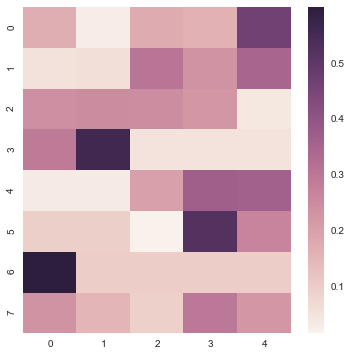

In [27]:
plot_heatmap(5,13)

In [28]:
# Manual testing
print(data.ix[12,'Narrative'])


A Beech 1900D aircraft operated by North-Wright Airways, was conducting flight NWL125 from Norman Wells, Canada to Tulita, Canada. The flight crew was trying to initiate a right hand turn on the ramp after landing to park the aircraft and during the manoeuvre, they felt the aircraft started to slip on the slippery surface. The captain tried to do a recovery manoeuvre by applying differential power, reverse, and braking, however these manoeuvres were unsuccessful. The left wing came into contact with the airport building, sheering off the left winglet and wing tip down to the wing rib located below the wing fence. The aircraft continued past the building before coming to rest with the winglet and debris resting behind it. The 4 passengers and 2 crew members disembarked without any injury.


### Create a new feature with the topic name onto the dataframe


### Check accuracy of topic modelling

## Model 2: Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

## The stop words need to be modified, Is it possible to Stemmatize?

## Count Vectorize the Text

In [ ]:
# Import library 

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Join all the Incident Narratives

data_text = [summary for summary in data['Narrative']]

In [ ]:
# Use Count vectorizer to get the  most used names in titles
# Analyzer - I want to analyze by words and not charachter
# Tokenizer - None
# Preprocessor - 
# Stop words - Use basic english stop words initially
# Maximum features - 1000
# Ngram Range 2-3
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
                             preprocessor = None,stop_words = 'english',max_features = 5000, ngram_range = (1,1)) 

In [ ]:
# Fit the text to the vectorizer model

data_text_features = vectorizer.fit_transform(data_text)

# Get the words and the count from the model

data_text_words = pd.DataFrame(vectorizer.transform(data_text).todense(), columns=vectorizer.get_feature_names())

In [ ]:
list(data_text_words.columns)

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# Creating stop words database for all the numbers
stop = stopwords.words('english')
stop += ['00', '000', '01', '02', '03', '04', '04r', '05', '050', '05l', '05r', '06', '06r', '07', '08', '080', '09', '09r', '10', '100', '1000', '10000', '102', '103', '104', '1049', '105', '106', '107', '108', '109', '10deg', '10l', '11', '110', '1100', '111', '111f', '112', '113', '114', '115', '116', '117', '118', '118a', '119', '11f', '11s', '12', '120', '1200', '12000', '121', '361', '376','122', '123', '124', '124c', '125', '128', '129', '12bk', '13', '130', '1300', '130b', '130e', '130h', '130j', '131', '133', '134', '135', '135a', '139', '13l', '14', '140', '1400', '141', '1420', '145', '14500', '146', '148', '15', '150', '1500', '153', '154', '157', '158', '159', '15deg', '16', '160', '1600', '163', '165', '166', '168', '16r', '17', '170', '1700', '172', '175', '1750', '17l', '18', '180', '1800', '180deg', '185', '188', '19', '190', '1900', '1900c', '1900d', '191', '1936', '1938', '1940', '1941', '1942', '1943', '1944', '1945', '1948', '1949', '1950', '1951', '1953', '1954', '1955', '1957', '1963', '1964', '1966', '1968', '1969', '1972', '1973', '1974', '1978', '1979', '1980', '1981', '1982', '1983', '1985', '1986', '1988', '1990', '1991', '1992', '1993', '1994', '1997', '1998', '1999', '19r', '1a', '1a10', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '200c', '201', '2011', '2013', '2015', '202', '203', '2050', '207', '208', '208b', '20deg', '21', '210', '211', '212', '215', '22', '220', '2200', '222', '225', '227', '228', '22l', '23', '230', '2300', '232', '235', '24', '240', '2400', '241', '242', '24b', '24l', '24r', '24rv', '25', '250', '2500', '25l', '26', '260', '265', '266', '26b', '26l', '27', '270', '2700', '27l', '27r', '28', '280', '2800', '285', '28l', '28r', '29', '290', '29l', '2a', '2r', '2t', '30', '300', '3000', '304', '306', '30deg', '31', '310', '31242', '31243', '314', '315', '31l', '31r', '32', '320', '3200', '320o', '322', '325', '328', '32l', '32r', '33', '330', '3300', '330o', '336', '338', '33l', '34', '340', '340b', '340o', '345', '35', '350', '3500', '350o', '35a', '35l', '36', '360', '3600', '37', '38', '39', '390', '3a', '3c', '3deg', '3m', '3mge', '3t', '40', '400', '4000', '41', '410', '410uvp', '42', '420', '4200', '43', '430', '436', '44', '440', '45', '450', '4500', '45deg', '46', '46d', '47', '470', '4700', '47a', '47b', '47d', '47s', '48', '49', '50', '500', '5000', '501', '504', '50832', '50deg', '51', '52', '525', '53', '54', '5400', '55', '550', '5500', '56', '57', '58', '580', '59', '5a', '5h', '5n', '5nm', '5y', '60', '600', '6000', '601', '61', '610', '62', '620', '63', '631', '64', '640', '65', '650', '6500', '66', '67', '68', '6a', '6e', '70', '700', '7000', '707', '71', '710', '72', '720', '725', '727', '73', '737', '74', '747', '748', '75', '750', '7500', '756', '757', '76', '767', '767s', '76md', '770', '777', '78', '78505', '7nm', '80', '800', '8000', '801', '81', '811', '812', '82', '8235', '8241', '82a', '83', '84', '85', '850', '8500', '86', '87', '88', '8807', '89', '8q', '8th', '90', '900', '9000', '90deg', '91', '910', '92', '93', '931', '94', '95', '96', '97', '98', '99', '990', '9k', '9n', '9q', 'a100', 'a300', 'a310', 'a319', 'a320', 'a321', 'a330', 'a6m2', 'aa', 'aaa', 'aab', 'aaf', 'ab', 'ababa']
stop += ['08r', '1009', '101', '1011', '104b', '144', '21st', '221', '22285', '231', '23l', '300yds', '301', '3100', '318', '319', '31de', '321', '321b', '324', '3277', '33666', '33r', '380', '3800', '395', '39a', '3mce', '400a', '402q', '40563', '40deg', '415', '42e', '42w', '4300', '451', '460', '701', '702', '712', '730', '740', '75a', '76td', '7700', '775', '780', '78270', '78462', '785', '797', '800xp', '823', '841', '8as', '8r', '901', '919', '920', '926', '980', '9j', '9l', '9m']
stop += ['675','680','6800','6b']
# stop.append("need")

In [ ]:
# Use Count vectorizer to get the  most used names in titles
# Analyzer - I want to analyze by words and not charachter
# Tokenizer - None
# Preprocessor - 
# Stop words - Use basic english stop words initially
# Maximum features - 1000
# Ngram Range 2-3
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
                             preprocessor = None,stop_words = stop,max_features = 1000, ngram_range = (2,3)) 

In [ ]:
# Fit the text to the vectorizer model

# Fit - Learn the document terms
# Transform - Create the term document array

# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

data_text_features = vectorizer.fit_transform(data_text)
data_text_features

In [ ]:
data_text_features.shape
# There are 8172 descriptions which are the rows and 1000 columns which are the frequent n-grams

In [ ]:
columns=vectorizer.get_feature_names()

In [ ]:
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(data_text_features.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [ ]:
# From the words its clear these are the common words in english and we need to avoid those. Implementing the
# stop word "english"

In [ ]:
# Fit the text to the vectorizer model

data_text_features = vectorizer.fit_transform(data_text)

# Get the words and the count from the model

data_text_words = pd.DataFrame(vectorizer.transform(data_text).todense(), columns=vectorizer.get_feature_names())

In [ ]:
data_text_words.sum().nlargest(1000)

In [ ]:
cvt = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
X_all = cvt.fit_transform(data_scientist_df['jd'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:20]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
CountVectorizer(strip_accents='ascii').build_analyzer()('pilot/error')

In [ ]:
# Use Count vectorizer to get the  most used names in titles
# Analyzer - I want to analyze by words and not charachter
# Tokenizer - None
# Preprocessor - 
# Stop words - Use basic english stop words initially
# Maximum features - 1000
# Ngram Range 2-3
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
                             preprocessor = None,stop_words = stop,max_features = 1000, ngram_range = (2,3)).build_analyzer()('pilot/error')

In [ ]:
# Fit the text to the vectorizer model

data_text_features = vectorizer.fit_transform(data_text)

# Get the words and the count from the model

data_text_words = pd.DataFrame(vectorizer.transform(data_text).todense(), columns=vectorizer.get_feature_names())

In [ ]:
data_text_words.sum().nlargest(1000)